In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal

def U_f(n): # reference f(x)
    qc = QuantumCircuit(n)
    qc.x(0)
    for i in range(n):
        qc.h(i)  # 데이터 큐비트에 Hadamard 적용
    return qc.to_gate(label="U_f")


def Ansatz(n): # U_theta, TwoLocal self-adjoint
    ansatz = TwoLocal(n, rotation_blocks='ry',
              entanglement_blocks='cz', entanglement='linear',
              reps=1, insert_barriers=False)
    return ansatz


def Reference(n):
    f_state = Statevector.from_instruction(U_f(n))
    f_operator = f_state.to_operator()
    f_reference = SparsePauliOp.from_operator(f_operator)
    return f_reference


'''
In Sato_2021 paper, using this method, called Hadamard test
But, in this case, we don't need to use Hadamard test.
Just use U_f for reference function and U_theta for ansatz.    
def ansatz(n, theta):
    """
    |f, psi> 
    """
    qc = QuantumCircuit(n)
    
    qc.h(n-1)  

    Uf = U_f(n-1)  
    qc.append(Uf.control(1), [n-1] + list(range(n-1)))  

    qc.x(n-1)
    
    Utheta = U_theta(n-1, theta) 
    qc.append(Utheta.control(1), [n-1] + list(range(n-1)))

    #qc.h(n-1)
    return qc
'''

'\nIn Sato_2021 paper, using this method, called Hadamard test\nBut, in this case, we don\'t need to use Hadamard test.\nJust use U_f for reference function and U_theta for ansatz.    \ndef ansatz(n, theta):\n    """\n    |f, psi> \n    """\n    qc = QuantumCircuit(n)\n\n    qc.h(n-1)  \n\n    Uf = U_f(n-1)  \n    qc.append(Uf.control(1), [n-1] + list(range(n-1)))  \n\n    qc.x(n-1)\n\n    Utheta = U_theta(n-1, theta) \n    qc.append(Utheta.control(1), [n-1] + list(range(n-1)))\n\n    #qc.h(n-1)\n    return qc\n'

In [2]:
X = np.array([[0, 1], 
              [1, 0]])

I = np.array([[1, 0],
              [0, 1]])

zero = np.array([[1, 0]])
one = np.array([[0, 1]])

I_0 = zero.T @ zero

I_1 = one.T @ one

def P(n):
    return np.roll(np.eye(2**n), shift=1, axis=0)
#P = np.roll(np.eye(2**n), shift=1, axis=0)  # Shift operator

def tensor_prod(M, n):
    M_n = M
    for i in range(1, n-1):
        M_n = np.kron(M_n, M)
    return M_n

def get_A_even(n):
    A_even = np.kron(np.eye(2**(n-1)), I - X)
    return A_even

def get_A_odd(n):
    return np.linalg.inv(P(n)) @ get_A_even(n) @ P(n)

def get_A_periodic(n):
    return get_A_even(n) + get_A_odd(n)

def get_A_diriclet(n):
    A_periodic = get_A_periodic(n)
    return A_periodic + np.linalg.inv(P(n)) @ np.kron(tensor_prod(I_0, n), X) @ P(n)

def get_A_neumann(n):
    A_periodic = get_A_periodic(n)
    return A_periodic - np.linalg.inv(P(n)) @ np.kron(tensor_prod(I_0, n), I-X) @ P(n)

In [3]:
# observable preparation (translation of A)
from qiskit.quantum_info import Operator
from qiskit.circuit.library import StatePreparation
from qiskit.quantum_info import SparsePauliOp

def Observable(A):
    A_operator = Operator(A)
    A_observable = SparsePauliOp.from_operator(A_operator)
    return A_observable

In [28]:
num_qubits = 2
reference = Reference(num_qubits)

# sato_2021 
observable = Observable(get_A_diriclet(num_qubits))  # 또는 A_Neumann, A_periodic 등

#2-qubits test observable
#observable = SparsePauliOp.from_list([("II", 2), ("XX", -3), ("YY", 2), ("ZZ", -4)])
    
ansatz = Ansatz(num_qubits)

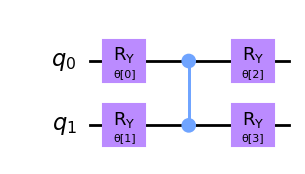

In [29]:
ansatz.decompose().draw('mpl', fold=-1, style='clifford')

In [30]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import Session, EstimatorOptions
import os

IBM_KEY = os.getenv("IBM_API_KEY")

#Select the least busy backend:

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='yonsei-dedicated/internal/ybscandid',
    #instance='ibm-q/open/main',
    token=IBM_KEY
)

backend = service.least_busy(
    operational=True, min_num_qubits=ansatz.num_qubits, simulator=False
)

# generate a simulator that mimics the real quantum system with the latest calibration results
backend_sim = AerSimulator.from_backend(backend)

C:\Users\Jeongbin\AppData\Local\Temp\ipykernel_14960\3250198410.py:12: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService(


In [31]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
isa_ansatz = pm.run(ansatz)
isa_reference = reference.apply_layout(layout=isa_ansatz.layout)
isa_observable = observable.apply_layout(layout=isa_ansatz.layout)

In [32]:
from scipy.stats.qmc import Sobol
import numpy as np

dim = ansatz.num_parameters  # ansatz의 파라미터 개수
qubits = ansatz.num_qubits  # ansatz의 큐빗 개수
n_samples = (2**int(np.ceil(dim * np.log2(3)))) #  2^n승 꼴, 이거 조정 필요

sobol = Sobol(d=dim, scramble=True)
params = sobol.random(n=n_samples)
params = -np.pi + 2 * np.pi * params  # [-pi, pi] 범위로 변환
print(params.shape)
print(dim)

(128, 4)
4


In [33]:
numerator_job_ids = []
denominator_job_ids = []

estimator_options = EstimatorOptions(
    #resilience_level=1, # not need for real backend
    default_shots=10000
)

batch_size = 2

cost_list = []
r_list = []

with Session(backend=backend_sim) as session:
    estimator = Estimator(mode=session, options=estimator_options)
    for i in range(0, n_samples, batch_size):
        batch_params = params[i:i + batch_size]
        if len(batch_params) < batch_size:
            continue  # Skip if the last batch is not full
        
        numerator_inputs = [(isa_ansatz, isa_reference, [params]) for params in batch_params]
        denominator_inputs = [(isa_ansatz, isa_observable, [params]) for params in batch_params]

        numerator_job = estimator.run(numerator_inputs)
        denominator_job = estimator.run(denominator_inputs)

        if session._backend.configuration().simulator:
            numerator_results = numerator_job.result()
            denominator_results = denominator_job.result()

            # 기대값 추출
            numerator_list = [num.data.evs[0] for num in numerator_results]
            denominator_list = [denom.data.evs[0] for denom in denominator_results]
            cost = 0
            r = 0
            # 각 샘플별 cost 계산
            for num_val, denom_val in zip(numerator_list, denominator_list):
                if abs(denom_val) < 1e-10:
                    cost = np.inf  # Avoid division by zero
                    r = np.inf
                else:
                    cost = -0.5 * (num_val ** 2) / denom_val
                    r = num_val / denom_val
                
                cost_list.append(cost)
                r_list.append(r)

        numerator_job_ids.append(numerator_job.job_id())
        denominator_job_ids.append(denominator_job.job_id())
        print(f"Submitted batch ({i // batch_size + 1} / {n_samples // batch_size}):")
        print(f"\tNumerator job ID: {numerator_job.job_id()}")
        print(f"\tDenominator job ID: {denominator_job.job_id()}")
        if session._backend.configuration().simulator:
            print(f"\tCost: {cost_list[i:i + batch_size]}")
        
session.close()


Submitted batch (1 / 64):
	Numerator job ID: 9d5ca155-ec59-40c2-80fe-0c4eaa7e31a5
	Denominator job ID: 9b1ab585-337b-4b6d-80d1-f099f2460ba7
	Cost: [-0.02271100322196229, -0.0045812316457183085]
Submitted batch (2 / 64):
	Numerator job ID: 36c33709-fe77-4d6b-9149-d09faec9503b
	Denominator job ID: 9430e7e2-a8c1-403d-aa0f-96ff698f4eb4
	Cost: [-0.003763033998773587, -0.00012938684834123225]
Submitted batch (3 / 64):
	Numerator job ID: 310407f1-5334-4174-8378-fc513f5c9e96
	Denominator job ID: 151e8988-1415-41ba-a59a-a5bc6465ae7f
	Cost: [-0.0006579250633522374, -0.020880651282365166]
Submitted batch (4 / 64):
	Numerator job ID: a9368187-7d0e-4861-aa32-d4084b5ad993
	Denominator job ID: 3d334e5d-ef7c-4769-b38b-90a300ecedf0
	Cost: [-0.00018750409433344306, -0.000699637315503972]
Submitted batch (5 / 64):
	Numerator job ID: 5ed6f6d9-1ef1-4a64-9e2d-1644e50d57bd
	Denominator job ID: 29e3c5e5-faa6-4e53-bb7a-be677723a280
	Cost: [-0.11069288277309494, -0.011227111261675448]
Submitted batch (6 / 64):


In [34]:
def r_cost_func_qsr(numerator_id, denominator_id, service, epsilon=1e-10):

    # IBM Job 객체 불러오기
    numerator_job = service.job(numerator_id)
    denominator_job = service.job(denominator_id)

    # 결과 추출
    numerator_result = numerator_job.result()
    denominator_result = denominator_job.result()

    # expectation value 추출 (estimator 기반)
    numerator = numerator_result.data.evs[0]
    denominator = denominator_result.data.evs[0]

    # 0 나눗셈 방지
    if abs(denominator) < epsilon:
        return np.inf, np.inf

    # 최종 Cost 계산
    cost = -0.5 * (numerator ** 2) / denominator
    r = numerator / denominator
    return cost, r


In [35]:
def r_cost_list_func_qsr(numerator_job_ids, denominator_job_ids, service, epsilon=1e-10):
    cost_list = []
    r_list = []
    for (num_id, denom_id) in zip(numerator_job_ids, denominator_job_ids):
        
        cost, r = r_cost_func_qsr(num_id, denom_id, service, epsilon)
        cost_list.append(cost)
        r_list.append(r)

    return cost_list, r_list

In [36]:
from qiskit_ibm_runtime import QiskitRuntimeService
import os
IBM_KEY = os.getenv("IBM_API_KEY")  

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='yonsei-dedicated/internal/ybscandid',
    #instance='ibm-q/open/main',
    token=IBM_KEY
)

C:\Users\Jeongbin\AppData\Local\Temp\ipykernel_14960\2047524674.py:5: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, "ibm_cloud", "ibm_quantum_platform", and "local" will be the only valid channels. Open Plan users should migrate now.  All other users should review the migration guide (https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp)to learn when to migrate.
  service = QiskitRuntimeService(


In [37]:
#cost_list, r_list = r_cost_list_func_qsr(numerator_job_ids, denominator_job_ids, service)

In [38]:
from sklearn.gaussian_process import GaussianProcessRegressor
from scipy.optimize import minimize

# Step 1: surrogate 모델 학습
gpr = GaussianProcessRegressor().fit(params, cost_list)

# Step 2: surrogate 기반 cost 함수
def surrogate_expectation(theta):
    return gpr.predict([theta])[0]


In [39]:
# Callback 함수로 기록
qsr_cost_history = []

def callback(theta):
    value = surrogate_expectation(theta)
    qsr_cost_history.append(value)
    print(f"Step {len(qsr_cost_history)}: cost = {value:.6f}")

In [40]:
num_params = ansatz.num_parameters
results = []

initial_guesses = [np.eye(num_params)[i] for i in range(num_params)]

for idx, x0 in enumerate(initial_guesses):
    res_qsr = minimize(
        surrogate_expectation, 
        x0, 
        method="L-BFGS-B", 
        options={"maxiter": 1000}, 
        callback=callback, 
        tol=1e-10
    )
    print(res_qsr)
    results.append(res_qsr.fun)

Step 1: cost = -0.008050
Step 2: cost = -0.009270
Step 3: cost = -0.011197
Step 4: cost = -0.024814
Step 5: cost = -0.027756
Step 6: cost = -0.032344
Step 7: cost = -0.038590
Step 8: cost = -0.051599
Step 9: cost = -0.053136
Step 10: cost = -0.063722
Step 11: cost = -0.068703
Step 12: cost = -0.069701
Step 13: cost = -0.069733
Step 14: cost = -0.113118
Step 15: cost = -0.113121
Step 16: cost = -0.113712
Step 17: cost = -0.113804
Step 18: cost = -0.113886
Step 19: cost = -0.113886
Step 20: cost = -0.113886
Step 21: cost = -0.113886
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: -0.11388559957574658
        x: [ 2.152e+00  1.026e-01  2.563e+00  1.347e+00]
      nit: 21
      jac: [ 1.388e-09  6.939e-09  2.776e-09 -6.939e-09]
     nfev: 185
     njev: 37
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
Step 22: cost = -0.056024
Step 23: cost = -0.063833
Step 24: cost = -0.070116
Step 25: cost = -0.074835
Step 26: cost = -0.08


[Optimization Summary]
fun      : -0.4267794865193681
x        : [-1.502564  1.060539 -1.954475  1.353229]
nfev     : 115
message  : CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
success  : True


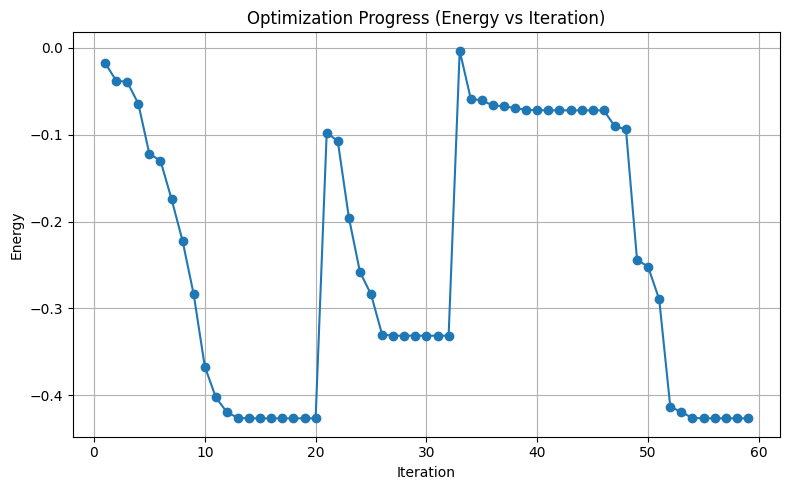

In [22]:
import matplotlib.pyplot as plt
# -------------------------
# 8. 결과 요약
# -------------------------
print("\n[Optimization Summary]")
print("fun      :", res_qsr.fun)
print("x        :", np.round(res_qsr.x, 6))
print("nfev     :", res_qsr.nfev)
print("message  :", res_qsr.message)
print("success  :", res_qsr.success)

# -------------------------
# 9. 최적화 과정 시각화
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(qsr_cost_history) + 1), qsr_cost_history, marker='o')
plt.title("Optimization Progress (Energy vs Iteration)")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.grid(True)
plt.tight_layout()
plt.show()


In [41]:
def r_cost_func_vqe(params, ansatz, observable, reference, estimator):
    num_inputs = (ansatz, reference, [params])
    denom_inputs = (ansatz, observable, [params])
    
    num_cost = estimator.run([num_inputs]).result()[0].data.evs[0]
    denom_cost = estimator.run([denom_inputs]).result()[0].data.evs[0]
    cost = -0.5 * (num_cost ** 2) / denom_cost if abs(denom_cost) > 1e-10 else np.inf
    r = num_cost / denom_cost if abs(denom_cost) > 1e-10 else np.inf
    return cost, r

In [42]:
def r_func_vqe(params, ansatz, observable, reference, estimator):
    _, r = r_cost_func_vqe(params, ansatz, observable, reference, estimator)
    return r

def cost_func_vqe(params, ansatz, observable, reference, estimator):
    cost, _ = r_cost_func_vqe(params, ansatz, observable, reference, estimator)
    return cost

In [43]:
from scipy.optimize import minimize
from qiskit.primitives import StatevectorEstimator


estimator = StatevectorEstimator()

# Callback 함수로 기록
vqe_cost_history = []
vqe_r_history = []

def callback(theta):
    cost, r = r_cost_func_vqe(theta, ansatz, observable, reference, estimator)
    vqe_cost_history.append(cost)
    vqe_r_history.append(r)
    print(f"Step {len(vqe_cost_history)}: cost = {cost:.6f}")

In [44]:
x0 = np.zeros(num_params)
for idx, x0 in enumerate(initial_guesses):
    res_vqe = minimize(
        cost_func_vqe, 
        x0, 
        args=(ansatz, observable, reference, estimator),
        method="L-BFGS-B", 
        options={"maxiter": 1000}, 
        callback=callback, 
        tol=1e-10
    )
    print(res_vqe)
    results.append(res_vqe.fun)
    

Step 1: cost = -0.001094
Step 2: cost = -0.143239
Step 3: cost = -0.143372
Step 4: cost = -0.144008
Step 5: cost = -0.144958
Step 6: cost = -0.144964
Step 7: cost = -0.144965
Step 8: cost = -0.144965
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: -0.1449645155815299
        x: [-1.839e+00  3.354e+00 -3.416e+00 -1.514e+00]
      nit: 8
      jac: [ 9.992e-08 -2.220e-08 -8.049e-08  6.106e-08]
     nfev: 90
     njev: 18
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
Step 9: cost = -0.119644
Step 10: cost = -0.138571
Step 11: cost = -0.144203
Step 12: cost = -0.144926
Step 13: cost = -0.144962
Step 14: cost = -0.144965
Step 15: cost = -0.144965
Step 16: cost = -0.144965
  message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
  success: True
   status: 0
      fun: -0.14496451558158738
        x: [ 2.134e-01  1.279e+00 -1.633e+00  2.978e-01]
      nit: 8
      jac: [ 0.000e+00  2.776e-09  2.776e-09  0.000e+00]
     n


[Optimization Summary]
fun      : -0.14496451558158688
x        : [-0.713504 -0.315176 -0.882188  1.812491]
nfev     : 60
message  : CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
success  : True


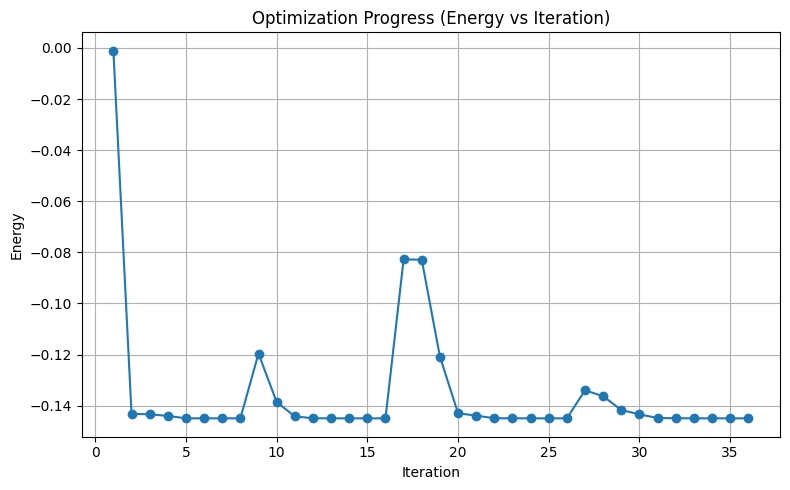

In [45]:
import matplotlib.pyplot as plt
# -------------------------
# 8. 결과 요약
# -------------------------
print("\n[Optimization Summary]")
print("fun      :", res_vqe.fun)
print("x        :", np.round(res_vqe.x, 6))
print("nfev     :", res_vqe.nfev)
print("message  :", res_vqe.message)
print("success  :", res_vqe.success)

# -------------------------
# 9. 최적화 과정 시각화
# -------------------------
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(vqe_cost_history) + 1), vqe_cost_history, marker='o')
plt.title("Optimization Progress (Energy vs Iteration)")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.grid(True)
plt.tight_layout()
plt.show()

#plt.figure(figsize=(8, 5))
#plt.plot(range(1, len(vqe_r_history) + 1), vqe_r_history, marker='o')
#plt.title("Optimization Progress (Energy vs Iteration)")
#plt.xlabel("Iteration")
#plt.ylabel("Energy")
#plt.grid(True)
#plt.tight_layout()
#plt.show()